### Import Libraries

In [1]:
from wrapper_functions_CAR64 import *
tf.config.run_functions_eagerly(True)
np.random.seed(10)

C:\Users\Admin-Dell\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
C:\Users\Admin-Dell\anaconda3\lib\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


TensorFlow version: 2.11.0. Expected: 2.7.0
TensorFlow Probability version: 0.19.0. Expected: 0.15.0


In [2]:
training2010 = pd.read_csv('../data/merged_wp_census_data2_081122.csv')
county_adj = pd.read_csv('../data/countyadj2.csv', index_col = 0)
models = ['pep', 'worldpop']
data_NY, adj_NY = subset_data_by_state(training2010, county_adj, 'New York', 'NY')

### Loading results and analyzing

In [10]:
local_dir = 'C:/Users/Admin-Dell/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
#local_dir = 'C:/Users/nickl/Dropbox/Nick_Cranston/HSPH/Research/Nethery Project/Data/'
file = local_dir + 'CAR_samples_NY_n10000_realdata_fl64_2models_June282023.pickle'
with open(file, "rb") as input_file:
     #CAR_samples, chain_samples, sampler_stat, mcmc_config, phi_true, u_true, data_sub = pickle.load(input_file)
    res_dict = pickle.load(input_file)

In [11]:
res_dict.keys()

dict_keys(['CAR_samples', 'chain_samples', 'sampler_stat', 'phi_true', 'u_true', 'data', 'adjacency', 'pivot_fit', 'pivot_DGP', 'models', 'mcmc_config'])

## Getting the gradient and likelihood values

In [13]:
target_log_prob_fn = get_log_prob_from_results(res_dict)
res = pull_gradient_wrapper(res_dict['chain_samples'], target_log_prob_fn, step_sizes = res_dict['sampler_stat'][0].numpy())

fixing tau2 and rho
when adding in tau2 and rho, need to update the likelihood function!
False


In [15]:
# (T, nchains, # counties, # models)
phi_list = res_dict['chain_samples']
phi_list.shape, phi_list[0].shape

(TensorShape([12500, 5, 62, 2]), TensorShape([5, 62, 2]))

In [16]:
target_log_prob_fn_CAR(phi_list[0]), target_log_prob_fn(phi_list[1000])

NameError: name 'target_log_prob_fn_CAR' is not defined

In [25]:
tau2 = 1
rho = 0.3
pivot = -1
data = res_dict['data']
Q = (1/tau2)*(np.diag(res_dict['adjacency'].sum(axis=1)) - rho*res_dict['adjacency'])
Q = tf.constant(Q, dtype = tf.float64)
    
def target_log_prob_fn_CAR(phi):
    #Q = (1/tau2)*(np.diag(adjacency.sum(axis=1)) - rho*adjacency)
    #Q = tf.constant(Q, dtype = tf.float64)
        
    ll = tf.Variable(0., dtype = tf.float64)
    A = tf.Variable(0., dtype = tf.float64)
    B = tf.Variable(0., dtype = tf.float64)
    C = tf.Variable(0., dtype = tf.float64)
    
    for chain in range(phi.shape[0]):
        # (1) Prob of the CAR random effect values
        ll_chain = -0.5*tf.reduce_mean(tf.linalg.diag_part(
            tf.linalg.matmul(phi[chain,:,:],tf.linalg.matmul(Q, phi[chain,:,:]), transpose_a = True))) 
        A = A + ll_chain
        
    # add in determinant values
    #log_det = tf.constant(np.linalg.slogdet(Q.numpy)[1], dtype = tf.float64)
    log_det = tf.constant(np.linalg.slogdet(Q)[1], dtype = tf.float64)
    #log_det = tf.linalg.logdet(Q)[1], dtype = tf.float64
    B = 0.5*phi.shape[0]*len(models)*log_det
    
    if(pivot == -1):
        # get exponentiated values and sum across models
        exp_phi = tf.math.exp(phi)
        exp_phi_rows = tf.reduce_sum(exp_phi, 2)
    elif(pivot in range(3)):
        phi_np = phi.numpy()
        phi_np = np.insert(phi_np, pivot, 0., axis = 2)
        exp_phi = tf.math.exp(tf.constant(phi_np))
        exp_phi_rows = tf.reduce_sum(exp_phi, 2)
    else:
        raise Exception('Pivot needs to be -1, 0, 1, or 2')
    
    # get model weights and calculate mean estimate
    u = exp_phi/exp_phi_rows[...,None]
      
    tmp = data[models].values*u
    n = tf.reduce_sum(tmp, axis = 2)
    
    # update the log likelihood 
    C = tf.reduce_sum([np.sum(data['census']*np.log(n[chain,:]) - n[chain,:]) for chain in range(phi.shape[0])])
    
    D = A + B + C
    return(A, B, C, D)  

In [26]:
target_log_prob_fn_CAR(phi_list[0]), target_log_prob_fn_CAR(phi_list[1000])

((<tf.Tensor: shape=(), dtype=float64, numpy=-5.32955883879778>,
  <tf.Tensor: shape=(), dtype=float64, numpy=461.63020202749533>,
  <tf.Tensor: shape=(), dtype=float64, numpy=1215950146.2381792>,
  <tf.Tensor: shape=(), dtype=float64, numpy=1215950602.5388224>),
 (<tf.Tensor: shape=(), dtype=float64, numpy=-324.0333844495401>,
  <tf.Tensor: shape=(), dtype=float64, numpy=461.63020202749533>,
  <tf.Tensor: shape=(), dtype=float64, numpy=1215950211.753963>,
  <tf.Tensor: shape=(), dtype=float64, numpy=1215950349.3507805>))

In [27]:
phi_list[0][0] - phi_list[1000][0]

<tf.Tensor: shape=(62, 2), dtype=float32, numpy=
array([[ 1.97122127e-01, -8.61388370e-02],
       [-4.86589968e-02,  1.31433122e-02],
       [ 6.77793548e-02, -1.15135737e-01],
       [ 2.11852968e-01,  1.10723123e-01],
       [ 1.11876726e-01,  1.43977422e-02],
       [ 3.80838588e-02, -4.38684225e-02],
       [-3.96040380e-02, -1.51634306e-01],
       [ 2.05525216e-02, -2.95386557e-03],
       [ 1.36241421e-01,  5.36296219e-02],
       [ 1.95322603e-01, -1.11899078e-02],
       [ 1.68383718e-01, -3.87500599e-02],
       [ 8.15312117e-02, -4.70577776e-02],
       [ 7.51032382e-02,  1.89762227e-02],
       [-1.74288023e-02,  4.96817455e-02],
       [-2.60655046e-01,  1.82242557e-01],
       [-6.00833073e-02, -6.38696700e-02],
       [-8.68495405e-02,  2.37865657e-01],
       [ 2.84703076e-02, -1.11572415e-01],
       [ 1.56901963e-02, -1.00640714e-01],
       [-3.85514349e-02,  1.53132722e-01],
       [-6.20062985e-02, -3.77574414e-02],
       [-1.94975883e-01,  1.80744126e-01],
     

## Plotting MCMC diagnostics

In [14]:
#
tfp.math.reduce_logmeanexp(tf.minimum(res_dict['sampler_stat'][-1], 0.))
tf.math.exp(tfp.math.reduce_logmeanexp(tf.minimum(res_dict['sampler_stat'][-1], 0.)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.5319075>

In [15]:
res.logL.value_counts()

1.216282e+09    125
Name: logL, dtype: int64

Text(0, 0.5, 'log likelihood')

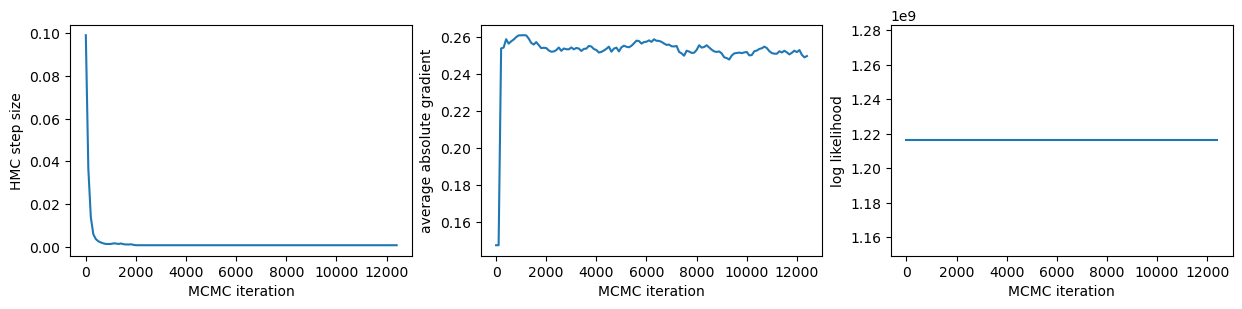

In [16]:
plt.rcParams['figure.figsize'] = [15, 3]

plt.subplot(1, 3, 1)
plt.plot(res['iter'],res['step_size'])
plt.xlabel('MCMC iteration')
plt.ylabel('HMC step size')

plt.subplot(1, 3, 2)
plt.plot(res['iter'],res['mean_abs_grad'])
plt.xlabel('MCMC iteration')
plt.ylabel('average absolute gradient')

plt.subplot(1, 3, 3)
plt.plot(res['iter'],res['logL'])
plt.xlabel('MCMC iteration')
plt.ylabel('log likelihood')

## Getting the rhat and ESS values

In [26]:
u_samples = phi_to_u(res_dict['chain_samples'])
ESS = tfp.mcmc.effective_sample_size(u_samples, cross_chain_dims = 1).numpy()
rhat = tfp.mcmc.potential_scale_reduction(res_dict['chain_samples'], independent_chain_ndims=1).numpy()
print(np.quantile(ESS, [0.5, 0.025, 0.975]))
print(np.quantile(rhat, [0.5, 0.025, 0.975]))

[12976.06396484  5249.5430542  20450.25673828]
[1.00028497 1.00001044 1.00190978]


In [ ]:
## Get the convergence diagnostics from model fits
rhat_vec = []
for key in res_dict.keys():
    #print(key)
    chain_samples = res_dict[key][1]
    u_samples = phi_to_u(chain_samples, res_dict[key][7])
    ESS = tfp.mcmc.effective_sample_size(u_samples, cross_chain_dims = 1).numpy()
    rhat = tfp.mcmc.potential_scale_reduction(chain_samples, independent_chain_ndims=1).numpy()
    print(np.quantile(ESS, [0.5, 0.025, 0.975]))
    print(np.quantile(rhat, [0.5, 0.025, 0.975]))

## Plotting the density of ensemble weights

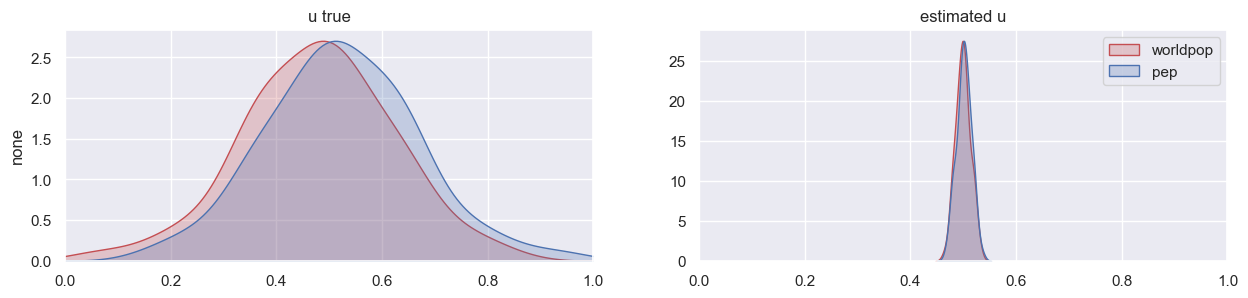

In [36]:
import seaborn as sns
#plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.figsize'] = [15, 3]
fig = plt.figure()

## The true u plot
plt.subplot(1, 2, 1)

CAR_df = pd.DataFrame(res_dict['u_true'][0,:,:], columns = res_dict['models'])
sns.set(style="darkgrid")
tt = sns.kdeplot(CAR_df['worldpop'], shade=True, color="r", label = 'worldpop')
tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
plt.ylabel(labels[pivot_DGP + 1])
plt.xlabel('')
plt.xlim(0,1)
plt.title('u true')

## The estimated u plot
CAR_ensemble_phis = tf.reduce_mean(res_dict['CAR_samples'][0], axis = 2).numpy()
u = phi_to_u(CAR_ensemble_phis, pivot = pivot_fit)
CAR_df = pd.DataFrame(u, columns = models)

plt.subplot(1, 2, 2)
sns.set(style="darkgrid")
tt = sns.kdeplot(CAR_df['worldpop'], shade=True, color="r", label = 'worldpop')
tt = sns.kdeplot(CAR_df["pep"], shade=True, color="b", label = 'pep')
#tt = sns.kdeplot(CAR_df["worldpop"], shade=True, color="g", label = 'worldpop')
#plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.xlim(0,1)
plt.title('estimated u')

plt.legend()
plt.show()

## Plotting scatterplots of the fitted vs true u values and predictions vs true

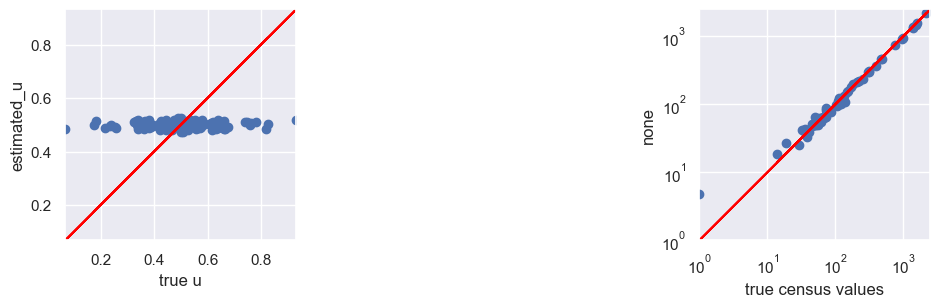

In [87]:
plt.rcParams['figure.figsize'] = [15, 3]
fig = plt.figure()

phi = res_dict['CAR_samples'][0]

predictions = np.empty(shape=(phi.shape[0], 
                              phi.shape[2]), 
                       dtype='float64')

u = np.empty(shape = phi.shape, dtype = 'float64')
for i in range(phi.shape[2]):
    u[:,:,i] = phi_to_u(phi[:,:,i], pivot = -1)
    predictions[:,i] = tf.reduce_sum(res_dict['data'][res_dict['models']].values*u[:,:,i], axis = 1)
   # predictions[:,i] = tf.reduce_sum(data_pivot[models].values*u, axis = 1)

y_pred = np.mean(predictions, axis = 1)
    

## Make the u plot    
CAR_df = pd.DataFrame(np.mean(u, axis = 2), columns = res_dict['models'])

plt.subplot(1, 2, 1)
x = np.ndarray.flatten(res_dict['u_true'][0,:,:].numpy())
y = np.ndarray.flatten(CAR_df.values)
plt.scatter(x, y)
plt.xlabel("true u")
plt.ylabel('estimated_u')

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

## obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
## add linear regression line to scatterplot 
#plt.plot(x, m*x+b, color = 'red')
## add y = x lin
plt.plot(x, x, color = 'red')

## Make the predictions plot
plt.subplot(1, 2, 2)

x = res_dict['data']['census']
y = y_pred
#y = y_pred.numpy()
plt.scatter(x, y)
plt.xlabel("true census values")
plt.ylabel(labels[pivot_fit + 1])

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y.astype('float64'), 1)

plt.xlim([min([min(x), min(y)]), max([max(x), max(y)])])
plt.ylim([min([min(x), min(y)]), max([max(x), max(y)])])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
ax.set_xscale("log")
ax.set_yscale("log")

## obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)
## add linear regression line to scatterplot 
#plt.plot(x, m*x+b, color = 'red')
## add y = x line
plt.plot(x, x, color = 'red')

plt.show()

## Plotting the chloroploth maps

In [ ]:
# Create the weights dict for plotting the outcomes

weights_dict = {
    "acs": CAR_ensemble_weights[:,0],
    "pep": CAR_ensemble_weights[:,1],
    "worldpop": CAR_ensemble_weights[:,2]
}

color_weights = make_color_norm(
    list(weights_dict.values())[1],   
    method="percentile")

In [ ]:
norm_weights_dict = {
    "acs": u[:,0],
    "pep": u[:,1],
    "worldpop": u[:,2]
}

color_norm_weights = make_color_norm(
    list(norm_weights_dict.values())[1],   
    method="percentile")

In [ ]:
import plotly
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
# df = pd.read_csv("https://raw.githubusercontent.com/plotly/datasets/master/fips-unemp-16.csv",
#                    dtype={"fips": str})
import matplotlib.colors as colors

import plotly.express as px

In [ ]:
for model_name in models:
    output = pd.DataFrame(np.column_stack([data_sub[["GEOID"]], weights_dict[model_name]]))
    output = output.set_axis(['GEOID', model_name], axis=1)
    output[model_name] = output[model_name].astype(float)
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

In [ ]:
# pd.concat([data_NY[["GEOID"]].reset_index(drop=True), pd.DataFrame( phi_true[0].numpy(), columns = models)], axis=1)
# pd.DataFrame( phi_true[0].numpy(), columns = models)

In [ ]:
full_phi = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(phi_true[0].numpy(), columns = models)], 
                        axis=1)

full_u = pd.concat([data_sub[["GEOID"]].reset_index(drop=True), 
                         pd.DataFrame(u_true[0].numpy(), columns = models)], 
                        axis=1)


#full_phi[['GEOID', 'acs']], full_u

In [ ]:
for model_name in models:
    output = full_phi[['GEOID', model_name]]
    fig = px.choropleth_mapbox(output, geojson=counties, locations='GEOID', color=model_name,
                           color_continuous_scale="Viridis",
                           #range_color=(0.05,0.07),
                           mapbox_style="carto-positron",
                           #mapbox_style='white-bg',
                           #featureidkey="properties.MWS_ID",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5#,
                           #labels={'unemp':'unemployment rate'}
                          )
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()